<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Get-SRA-runinfo-for-BioProjects" data-toc-modified-id="Get-SRA-runinfo-for-BioProjects-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get SRA runinfo for BioProjects</a></span></li><li><span><a href="#Get-sample-metadata" data-toc-modified-id="Get-sample-metadata-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Get sample metadata</a></span></li><li><span><a href="#Dataset-summary" data-toc-modified-id="Dataset-summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Dataset summary</a></span><ul class="toc-item"><li><span><a href="#per-bioproject" data-toc-modified-id="per-bioproject-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>per-bioproject</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-7.1.0.1"><span class="toc-item-num">7.1.0.1&nbsp;&nbsp;</span>Notes</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Creating-sample-files-for-LLMGQC" data-toc-modified-id="Creating-sample-files-for-LLMGQC-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Creating sample files for LLMGQC</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Creating a database of animal gut/feces metagenomes
  * metagenomes from various studies


# Var

In [2]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/'

metadata_file = file.path(work_dir, 'metadata', 'study_metadata_v1.xlsx')

# Init

In [179]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(readxl)

source('/ebio/abt3_projects/Georg_animal_feces/code/misc_r_functions/init.R')

# Load

In [75]:
metadata = readxl::read_xlsx(metadata_file) %>%
    filter(! is.na(SRA_project_accession))
metadata %>% dfhead

[1] 20  8


Animal,First_author,Year,DOI,Sequencer,Read_length,SRA_project_accession,Comments
Cattle,Stewart,2018,https://doi.org/10.1038/s41467-018-03317-6,HiSeq4000,NA,PRJEB21624,NA
Dog,Coelho,2018,https://doi.org/10.1186/s40168-018-0450-3,HiSeq2500,125,PRJEB20308,NA
Pig,Xiao,2016,https://doi.org/10.1038/nmicrobiol.2016.161,Hiseq2000,100,PRJEB11755,NA


# Get SRA runinfo for BioProjects

In [93]:
# function for getting files via entrez-direct
get_SRA_runinfo = function(bioproject, out_dir){
    out_file = file.path(out_dir, paste0(bioproject, '_runinfo.csv'))
    cmd = 'esearch -db sra -query {bioproject} | efetch --format runinfo > {out_file}'
    cmd = glue::glue(cmd, bioproject = bioproject, out_file = out_file)
    bash_job(cmd, conda_env='py3_genome')
    return(bioproject)
}

In [94]:
# fetching data
out_dir = file.path(work_dir, 'SRA_runinfo')
make_dir(out_dir)

X = as.list(metadata$SRA_project_accession)
lapply(X, get_SRA_runinfo, out_dir = out_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_runinfo 


[[1]]
[1] "PRJEB21624"

[[2]]
[1] "PRJEB20308"

[[3]]
[1] "PRJEB11755"

[[4]]
[1] "PRJEB22679"

[[5]]
[1] "PRJNA430956"

[[6]]
[1] "SRP156892"

[[7]]
[1] "PRJNA407583"

[[8]]
[1] "PRJNA532626"

[[9]]
[1] "SRP152412"

[[10]]
[1] "SRP119699"

[[11]]
[1] "PRJNA390686"

[[12]]
[1] "PRJNA336354"

[[13]]
[1] "PRJNA298982"

[[14]]
[1] "PRJNA417359"

[[15]]
[1] "SRP072790"

[[16]]
[1] "SRP072793"

[[17]]
[1] "PRJNA298982"

[[18]]
[1] "PRJNA381379"

[[19]]
[1] "SRP093602"

[[20]]
[1] "PRJEB29346"

In [95]:
# listing output
sra_info_files = list.files(out_dir, '*_runinfo.csv', full.names=TRUE) 
sra_info_files = data.frame(bioproject = gsub('_runinfo.csv', '', basename(as.character(sra_info_files))),
                            file_path = sra_info_files)
sra_info_files %>% dfhead

[1] 19  2


bioproject,file_path
PRJEB11755,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_runinfo/PRJEB11755_runinfo.csv
PRJEB20308,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_runinfo/PRJEB20308_runinfo.csv
PRJEB21624,/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_runinfo/PRJEB21624_runinfo.csv


In [96]:
# which (if any) are missing?
metadata %>%
    anti_join(sra_info_files, c('SRA_project_accession'='bioproject'))

Warning message:
“Column `SRA_project_accession`/`bioproject` joining character vector and factor, coercing into character vector”

Animal,First_author,Year,DOI,Sequencer,Read_length,SRA_project_accession,Comments


In [97]:
# loading the runinfo
sra_runinfo = list()
for(F in sra_info_files$file_path){
    z = file.info(F)
    if(!is.na(z$size) && z$size > 20){
        X = read.delim(F, sep=',') %>%
            mutate(spots = as.Num(spots),
                   bases = as.Num(bases),
                   avgLength = as.Num(avgLength),
                   size_MB = as.Num(size_MB),
                   TaxID = as.Num(TaxID))
        X$bioproject = gsub('_runinfo.csv', '', basename(F))
        sra_runinfo[[F]] = X
    }
}

sra_runinfo = do.call(rbind, sra_runinfo) 
rownames(sra_runinfo) = 1:nrow(sra_runinfo)
sra_runinfo %>% dfhead

Warning message in as.Num(spots):
“NAs introduced by coercion”Warning message in as.Num(bases):
“NAs introduced by coercion”Warning message in as.Num(avgLength):
“NAs introduced by coercion”Warning message in as.Num(size_MB):
“NAs introduced by coercion”Warning message in as.Num(TaxID):
“NAs introduced by coercion”Warning message in as.Num(spots):
“NAs introduced by coercion”Warning message in as.Num(bases):
“NAs introduced by coercion”Warning message in as.Num(avgLength):
“NAs introduced by coercion”Warning message in as.Num(size_MB):
“NAs introduced by coercion”Warning message in as.Num(TaxID):
“NAs introduced by coercion”Warning message in as.Num(spots):
“NAs introduced by coercion”Warning message in as.Num(bases):
“NAs introduced by coercion”Warning message in as.Num(avgLength):
“NAs introduced by coercion”Warning message in as.Num(size_MB):
“NAs introduced by coercion”Warning message in as.Num(TaxID):
“NAs introduced by coercion”Warning message in as.Num(spots):
“NAs introduced by

[1] 5021   48


Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,⋯,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash,bioproject
ERR1135708,2016-01-12 18:11:38,2016-01-13 00:12:58,552682,46362077,0,83,46,,https://sra-download.ncbi.nlm.nih.gov/sos/sra-pub-run-1/ERR1135708/ERR1135708.1,⋯,,,,BEIJING GENOME INSTITUTE,ERA534579,,public,C5BC3A93A1DC280CEB0A8BDFFF58332E,A22BDE2CF5CD3D8502AE1236F686749F,PRJEB11755
ERR1135709,2016-01-12 18:11:38,2016-01-13 00:12:55,262159,24065603,0,91,21,,https://sra-download.ncbi.nlm.nih.gov/sos/sra-pub-run-1/ERR1135709/ERR1135709.1,⋯,,,,BEIJING GENOME INSTITUTE,ERA534579,,public,6DF3AE70D375B79C8740DE713B45C18D,32BDA5FD3D72A1C94A349ABD9A0B8F82,PRJEB11755
ERR1135710,2016-01-12 18:11:38,2016-01-13 00:12:56,664337,63496249,0,95,54,,https://sra-download.ncbi.nlm.nih.gov/sos/sra-pub-run-1/ERR1135710/ERR1135710.1,⋯,,,,BEIJING GENOME INSTITUTE,ERA534579,,public,6186371F3279E2333CA54DA4AEF89C30,32429791E7D054DF7567F2571CAC9762,PRJEB11755


In [98]:
# summary
sra_runinfo %>%
    dplyr::select(Run, spots, bases, avgLength, size_MB, LibraryStrategy,
                  LibraryLayout, Platform, Model, TaxID, ScientificName) %>%
    summary

         Run           spots               bases             avgLength    
 Run       :  30   Min.   :     7743   Min.   :2.562e+06   Min.   : 78.0  
 ERR1135178:   1   1st Qu.:  1837648   1st Qu.:4.600e+08   1st Qu.:250.0  
 ERR1135179:   1   Median :  2323131   Median :5.823e+08   Median :250.0  
 ERR1135180:   1   Mean   :  5914846   Mean   :1.371e+09   Mean   :250.2  
 ERR1135181:   1   3rd Qu.:  3595855   3rd Qu.:8.892e+08   3rd Qu.:252.0  
 ERR1135182:   1   Max.   :159524720   Max.   :4.818e+10   Max.   :500.0  
 (Other)   :4986   NA's   :30          NA's   :30          NA's   :30     
    size_MB               LibraryStrategy       LibraryLayout 
 Min.   :    1.0   LibraryStrategy:  30   LibraryLayout:  30  
 1st Qu.:  174.0   WGS            :4353   PAIRED       :4432  
 Median :  230.0   Hi-C           :   2   SINGLE       : 559  
 Mean   :  670.8   OTHER          : 309                       
 3rd Qu.:  350.0   AMPLICON       : 327                       
 Max.   :21009.0      

In [112]:
# filtering
sra_runinfo_f = sra_runinfo %>%
    filter(spots > 1e6,
           avgLength >= 100,
           ! LibraryStrategy %in% c('Hi-C', 'AMPLICON'),
           LibraryLayout == 'PAIRED',
           ! Platform %in% c('ION_TORRENT'),
           ! TaxID %in% c(564, 315405, 1263854))

sra_runinfo_f %>% nrow %>% print
sra_runinfo_f$bioproject %>% unique %>% length %>% print

sra_runinfo_f %>%
    dplyr::select(Run, spots, bases, avgLength, size_MB, LibraryStrategy,
                  LibraryLayout, Platform, Model, TaxID, ScientificName) %>%
    summary           

[1] 4068
[1] 14


         Run           spots               bases             avgLength    
 ERR1135178:   1   Min.   :  1050368   Min.   :2.441e+08   Min.   :149.0  
 ERR1135179:   1   1st Qu.:  2052618   1st Qu.:5.142e+08   1st Qu.:250.0  
 ERR1135180:   1   Median :  2503500   Median :6.296e+08   Median :252.0  
 ERR1135181:   1   Mean   :  6909590   Mean   :1.621e+09   Mean   :248.7  
 ERR1135182:   1   3rd Qu.:  3958522   3rd Qu.:9.958e+08   3rd Qu.:252.0  
 ERR1135183:   1   Max.   :159524720   Max.   :4.818e+10   Max.   :365.0  
 (Other)   :4062                                                          
    size_MB               LibraryStrategy       LibraryLayout 
 Min.   :  109.0   LibraryStrategy:   0   LibraryLayout:   0  
 1st Qu.:  197.0   WGS            :4008   PAIRED       :4068  
 Median :  250.5   Hi-C           :   0   SINGLE       :   0  
 Mean   :  792.9   OTHER          :  60                       
 3rd Qu.:  398.0   AMPLICON       :   0                       
 Max.   :21009.0      

# Get sample metadata

* For each sample, get NCBI biosample data
* Using entrez + xml formatting script:

```
esearch -db sra -query <Sample> | elink -target biosample | efetch -format xml | cat | ./ncbi_biosample_info.py -
```

In [180]:
# creating commands
make_cmd = function(Sample, out_dir){
    exe = '/ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/ncbi_biosample_info.py'
    out_dir = file.path(out_dir, Sample)
    make_dir(out_dir, quite=TRUE)
    out_file = file.path(out_dir,'biosample_info.tsv')
    cmd = 'esearch -db sra -query {Sample} | elink -target biosample | efetch -format xml | cat | {exe} - {out_file}'
    cmd = glue::glue(cmd, Sample = Sample, exe = exe, out_file = out_file)
    return(cmd)
}

In [181]:
out_dir = file.path(work_dir, 'SRA_biosample_info')
make_dir(out_dir)

X = sra_runinfo_f$Sample %>% unique %>% as.list
cmds = lapply(X, make_cmd, out_dir=out_dir)
cmds %>% length %>% print
cmds[[1]]

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_biosample_info 
[1] 1096


esearch -db sra -query ERS970444 | elink -target biosample | efetch -format xml | cat | /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/ncbi_biosample_info.py - /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_biosample_info/ERS970444/biosample_info.tsv

In [182]:
conda_env = 'py3_genome'
ret = lapply(cmds, function(x) bash_job(x, conda_env=conda_env))

Warning message:
“running command ''bash' -c ". ~/.bashrc; conda activate py3_genome; esearch -db sra -query ERS970368 | elink -target biosample | efetch -format xml | cat | /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/ncbi_biosample_info.py - /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_biosample_info/ERS970368/biosample_info.tsv" 2>/dev/null' had status 1”Warning message:
“running command ''bash' -c ". ~/.bashrc; conda activate py3_genome; esearch -db sra -query ERS970223 | elink -target biosample | efetch -format xml | cat | /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study/ncbi_biosample_info.py - /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//SRA_biosample_info/ERS970223/biosample_info.tsv" 2>/dev/null' had status 1”Warning message:
“running command ''bash' -c ". ~/.bashrc; conda activate py3_genome; esearch -db sra -query SRS1873539 | elink -target biosample | efetch -format xml | cat | /ebio/a

**Note:** I re-ran those failed commands 'manually' on the command line

In [186]:
# list output files
biosample_info_files = list.files(out_dir, 'biosample_info.tsv', full.names=TRUE, recursive=TRUE)
biosample_info_files %>% length %>% print

[1] 1096


In [190]:
# combining output
biosample_info = list()
for(F in biosample_info_files){
    df = read.delim(F, sep='\t', header=FALSE)
    colnames(df) = c('Sample', 'BioSample', 'Tag', 'Attribute')
    biosample_info[[F]] = df
}

biosample_info = do.call(rbind, biosample_info)
rownames(biosample_info) = 1:nrow(biosample_info)
biosample_info %>% dfhead

[1] 73600     4


Sample,BioSample,Tag,Attribute
ERS1646961,SAMEA103957793,BioSample,
ERS1646961,SAMEA103957793,Ids,
ERS1646961,SAMEA103957793,Description,


In [192]:
# checking that all samples are present in bioinfo table
setdiff(sra_runinfo_f$Sample, biosample_info$Sample) %>% length %>% print
setdiff(biosample_info$Sample, sra_runinfo_f$Sample) %>% length %>% print

[1] 0
[1] 0


# Dataset summary

In [217]:
# formatting and joining
tags = c('Id', 'Id__2', 'Title', 'Alias', 'Organism', 'Name', 'host', 'SRA_accession' ,
         'collection_date', 'env_material', 'env_biome')

biosample_info_j = biosample_info %>% 
    filter(Tag %in% tags) %>%
    spread(Tag, Attribute) %>%
    inner_join(sra_runinfo_f %>% 
                   dplyr::select(Sample, BioSample, Run, BioProject, spots, bases, avgLength, size_MB, 
                                 LibraryStrategy, LibraryLayout, Platform, Model, TaxID, ScientificName),
               c('Sample', 'BioSample'))

biosample_info_j %>% dfhead

Warning message:
“Column `Sample` joining factors with different levels, coercing to character vector”Warning message:
“Column `BioSample` joining factors with different levels, coercing to character vector”

[1] 4068   25


Sample,BioSample,Alias,collection_date,env_biome,env_material,host,Id,Id__2,Name,⋯,spots,bases,avgLength,size_MB,LibraryStrategy,LibraryLayout,Platform,Model,TaxID,ScientificName
ERS1646961,SAMEA103957793,Sample_58,2014,gut,feces,Canis lupus familiaris,SAMEA103957793,ERS1646961,EBI,⋯,3638228,909557000,250,322,WGS,PAIRED,ILLUMINA,Illumina HiSeq 2500,749906,gut metagenome
ERS1646961,SAMEA103957793,Sample_58,2014,gut,feces,Canis lupus familiaris,SAMEA103957793,ERS1646961,EBI,⋯,3615718,903929500,250,320,WGS,PAIRED,ILLUMINA,Illumina HiSeq 2500,749906,gut metagenome
ERS1646961,SAMEA103957793,Sample_58,2014,gut,feces,Canis lupus familiaris,SAMEA103957793,ERS1646961,EBI,⋯,3579352,894838000,250,315,WGS,PAIRED,ILLUMINA,Illumina HiSeq 2500,749906,gut metagenome


## per-bioproject

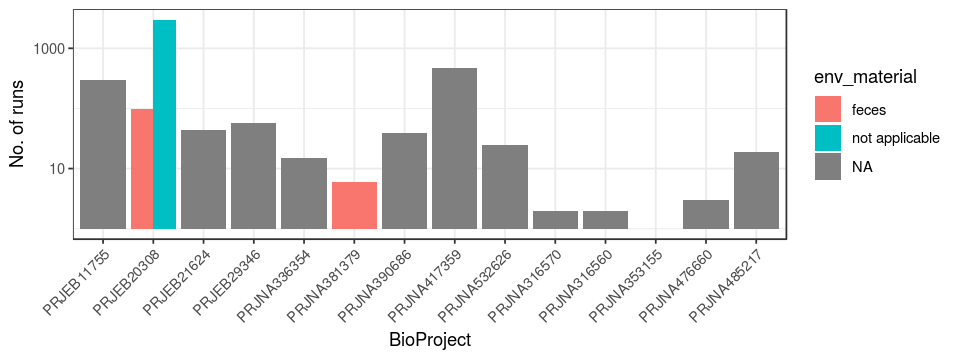

In [232]:
# env_material
p = biosample_info_j %>%
    group_by(BioProject, env_material) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    ggplot(aes(BioProject, n, fill=env_material)) +
    geom_bar(stat='identity', position='dodge') +
    scale_y_log10() +
    labs(y='No. of runs') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
   
dims(8, 3)
plot(p)

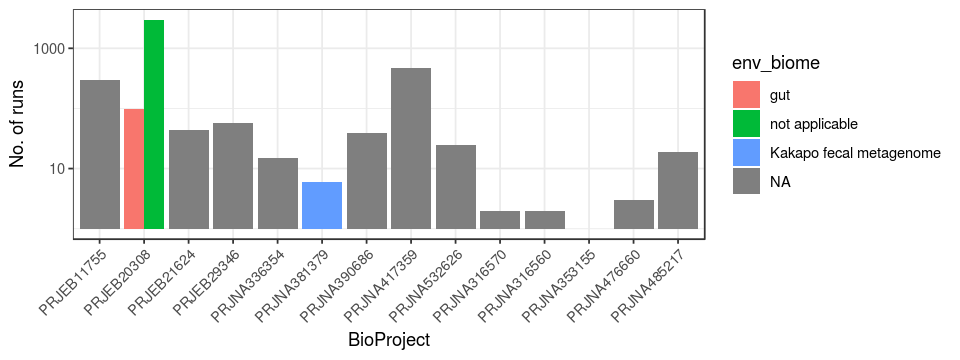

In [227]:
# env_biome
p = biosample_info_j %>%
    group_by(BioProject, env_biome) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    ggplot(aes(BioProject, n, fill=env_biome)) +
    geom_bar(stat='identity', position='dodge') +
    scale_y_log10() +
    labs(y='No. of runs') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
   
dims(8, 3)
plot(p)

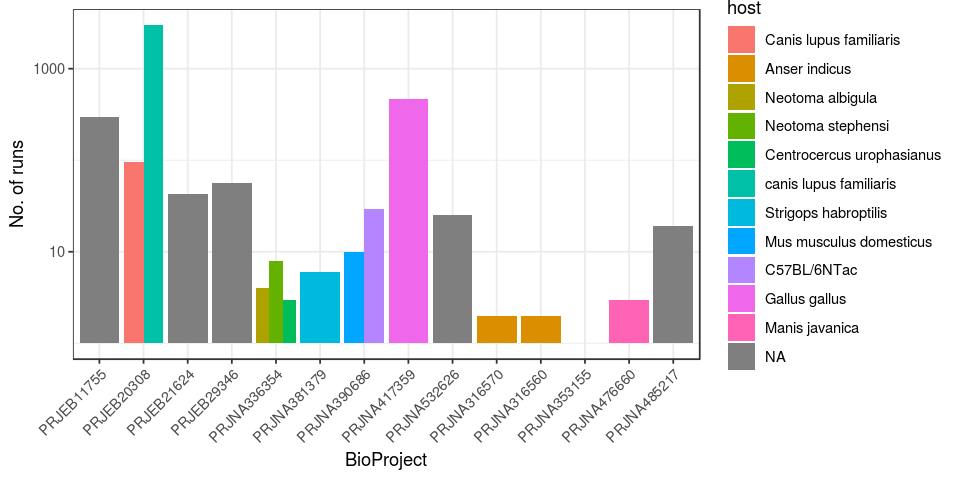

In [229]:
# host
p = biosample_info_j %>%
    group_by(BioProject, host) %>%
    summarize(n = n()) %>%
    ungroup() %>%
    ggplot(aes(BioProject, n, fill=host)) +
    geom_bar(stat='identity', position='dodge') +
    scale_y_log10() +
    labs(y='No. of runs') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )
   
dims(8, 4)
plot(p)

#### Notes

* `C57BL/6NTac` is the mouse strain

# Creating sample files for LLMGQC

* separating by bioproject

In [250]:
# formatting table
sra_runinfo_f_f = sra_runinfo_f %>%
    mutate(Lane = 1,
           Remote = Run) %>%
    rename('SampleID' = Sample,
           'Sample' = SampleName) %>%
    dplyr::select(Sample, Run, Lane, Remote,
                  spots, bases, avgLength, size_MB,
                  BioProject, bioproject, Study_Pubmed_id, BioSample, 
                  SampleID, SampleType, TaxID, ScientificName,
                  LibraryName, LibraryStrategy, LibrarySelection, LibrarySource, LibraryLayout, 
                  InsertSize, InsertDev, Platform, Model, source) 

sra_runinfo_f_f %>% dfhead

[1] 4068   26


Sample,Run,Lane,Remote,spots,bases,avgLength,size_MB,BioProject,bioproject,⋯,LibraryName,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,InsertSize,InsertDev,Platform,Model,source
SAMEA3663295,ERR1135468,1,ERR1135468,24873864,4875031192,195,3574,PRJEB11755,PRJEB11755,⋯,130421,WGS,other,METAGENOMIC,PAIRED,350,0,ILLUMINA,Illumina HiSeq 2000,
SAMEA3663296,ERR1135469,1,ERR1135469,29496968,5791369887,196,4228,PRJEB11755,PRJEB11755,⋯,130421,WGS,other,METAGENOMIC,PAIRED,350,0,ILLUMINA,Illumina HiSeq 2000,
SAMEA3663297,ERR1135470,1,ERR1135470,26828175,5160184344,192,3957,PRJEB11755,PRJEB11755,⋯,130420,WGS,other,METAGENOMIC,PAIRED,350,0,ILLUMINA,Illumina HiSeq 2000,


In [251]:
# adding relevant biosample info
tags = c('Title', 'Alias', 'Name', 'host', 'SRA_accession' ,
         'collection_date', 'env_material', 'env_biome')

sra_runinfo_f_f = sra_runinfo_f_f %>%
    inner_join(biosample_info %>% filter(Tag %in% tags) %>% spread(Tag, Attribute),
               c('SampleID'='Sample', 'BioSample'))

sra_runinfo_f_f %>% dfhead

Warning message:
“Column `SampleID`/`Sample` joining factors with different levels, coercing to character vector”Warning message:
“Column `BioSample` joining factors with different levels, coercing to character vector”

[1] 4068   34


Sample,Run,Lane,Remote,spots,bases,avgLength,size_MB,BioProject,bioproject,⋯,Model,source,Alias,collection_date,env_biome,env_material,host,Name,SRA_accession,Title
SAMEA3663295,ERR1135468,1,ERR1135468,24873864,4875031192,195,3574,PRJEB11755,PRJEB11755,⋯,Illumina HiSeq 2000,,ZXZ-5B,2013,NA,NA,NA,EBI,ERS970444,ZXZ-5B
SAMEA3663296,ERR1135469,1,ERR1135469,29496968,5791369887,196,4228,PRJEB11755,PRJEB11755,⋯,Illumina HiSeq 2000,,ZXZ-6B,2013,NA,NA,NA,EBI,ERS970445,ZXZ-6B
SAMEA3663297,ERR1135470,1,ERR1135470,26828175,5160184344,192,3957,PRJEB11755,PRJEB11755,⋯,Illumina HiSeq 2000,,ZXZ-7B,2013,NA,NA,NA,EBI,ERS970446,ZXZ-7B


In [261]:
# adding manually curated project metadata
sra_runinfo_f_f = sra_runinfo_f_f %>%
    left_join(metadata, c('bioproject'='SRA_project_accession')) 

sra_runinfo_f_f %>% dfhead

[1] 4068   41


Sample,Run,Lane,Remote,spots,bases,avgLength,size_MB,BioProject,bioproject,⋯,Name,SRA_accession,Title,Animal,First_author,Year,DOI,Sequencer,Read_length,Comments
SAMEA3663295,ERR1135468,1,ERR1135468,24873864,4875031192,195,3574,PRJEB11755,PRJEB11755,⋯,EBI,ERS970444,ZXZ-5B,Pig,Xiao,2016,https://doi.org/10.1038/nmicrobiol.2016.161,Hiseq2000,100,NA
SAMEA3663296,ERR1135469,1,ERR1135469,29496968,5791369887,196,4228,PRJEB11755,PRJEB11755,⋯,EBI,ERS970445,ZXZ-6B,Pig,Xiao,2016,https://doi.org/10.1038/nmicrobiol.2016.161,Hiseq2000,100,NA
SAMEA3663297,ERR1135470,1,ERR1135470,26828175,5160184344,192,3957,PRJEB11755,PRJEB11755,⋯,EBI,ERS970446,ZXZ-7B,Pig,Xiao,2016,https://doi.org/10.1038/nmicrobiol.2016.161,Hiseq2000,100,NA


In [262]:
# number of runs per bioproject
sra_runinfo_f_f$BioProject %>% as.character %>% table
cat('-----\n')
# number of samples per bioproject
sra_runinfo_f_f %>% distinct(BioProject, Sample) %>% .$BioProject %>% as.character %>% table

.
 PRJEB11755  PRJEB20308  PRJEB21624  PRJEB29346 PRJNA316560 PRJNA316570 
        295        3096          43          57           2           2 
PRJNA336354 PRJNA353155 PRJNA381379 PRJNA390686 PRJNA417359 PRJNA476660 
         15           1           6          39         465           3 
PRJNA485217 PRJNA532626 
         19          25 

-----


.
 PRJEB11755  PRJEB20308  PRJEB21624  PRJEB29346 PRJNA316560 PRJNA316570 
        295         129          43          57           2           2 
PRJNA336354 PRJNA353155 PRJNA381379 PRJNA390686 PRJNA417359 PRJNA476660 
         15           1           1          39         465           3 
PRJNA485217 PRJNA532626 
         19          25 

In [277]:
# number of runs per bioproject
sra_runinfo_f_f %>% 
    group_by(BioProject, bioproject) %>%
    summarize(n_runs = n()) %>%
    ungroup() %>%
    arrange(n_runs)

BioProject,bioproject,n_runs
PRJNA353155,SRP093602,1
PRJNA316570,SRP072790,2
PRJNA316560,SRP072793,2
PRJNA476660,SRP152412,3
PRJNA381379,PRJNA381379,6
PRJNA336354,PRJNA336354,15
PRJNA485217,SRP156892,19
PRJNA532626,PRJNA532626,25
PRJNA390686,PRJNA390686,39
PRJEB21624,PRJEB21624,43


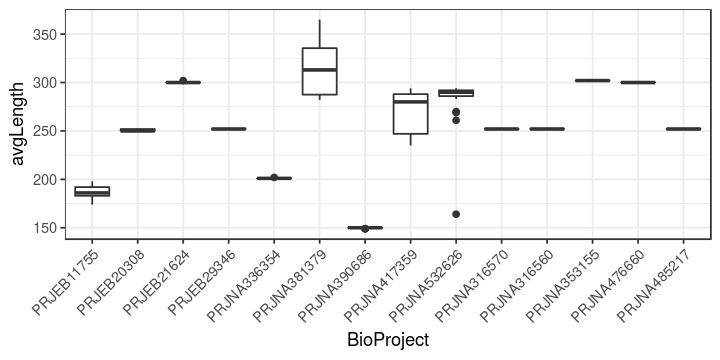

In [281]:
# read lengths per bioproject
p = sra_runinfo_f_f %>% 
    ggplot(aes(BioProject, avgLength)) +
    geom_boxplot() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

dims(6, 3)
plot(p)

In [273]:
bioprojects = sra_runinfo_f_f$BioProject %>% unique
for(B in bioprojects){
    df = sra_runinfo_f_f %>% filter(BioProject == B) 
    out_dir = file.path(work_dir, 'BioProjects', B)
    make_dir(out_dir)
    out_file = file.path(out_dir, 'samples.txt')
    write.table(df, out_file, sep='\t', quote=FALSE, row.names=FALSE)
    cat('File written:', out_file, '\n')
}

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB11755 
File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB11755/samples.txt 
Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB20308 
File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB20308/samples.txt 
Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB21624 
File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB21624/samples.txt 
Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB29346 
File written: /ebio/abt3_projects/Georg_animal_feces/data/metagenome/multi-study//BioProjects/PRJEB29346/samples.txt 
Directory already exists: /ebio/abt3_projects/Georg_anim

# sessionInfo

In [244]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/py3_physeq/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2 readxl_1.1.0   ggplot2_3.0.0  tidyr_0.8.1    dplyr_0.7.6   

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.17     cellranger_1.1.0 pillar_1.2.2     compiler_3.4.1  
 [5] plyr_1.8.4       bindr_0.1.1      base64enc_0.1-3  tools_3.4.1     
 [9] digest_0.6.15    uuid_0.1-2       jsonlite_1.5     evaluate_0.10.1 
[13] tibble_1.4.2     gtable_0.2.0     pkgconfig_2.0.1  rlang_0.2.1     
[17] IRdisplay_0.4.4  IRkernel_0.8.12  repr_0.15.0      withr_2.1.1     
[21] stringr_1.3.1    grid_3.4.1       tidyselect_